In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

In [2]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


## Load counts

In [3]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


## Apply normalizations to counts

In [4]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")

In [5]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


In [6]:
# Get transcript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

## Find  DE genes

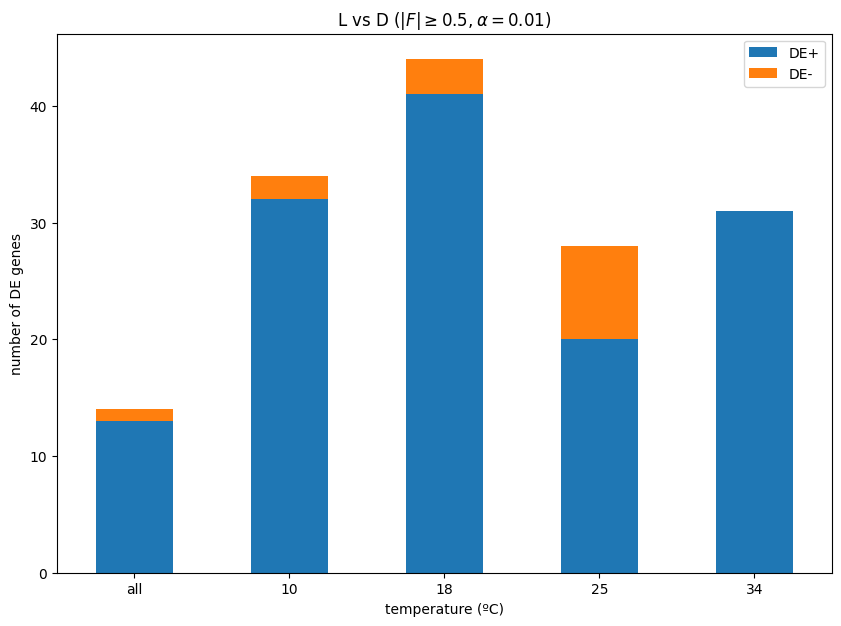

In [7]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [8]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes which are DE across all temperature values


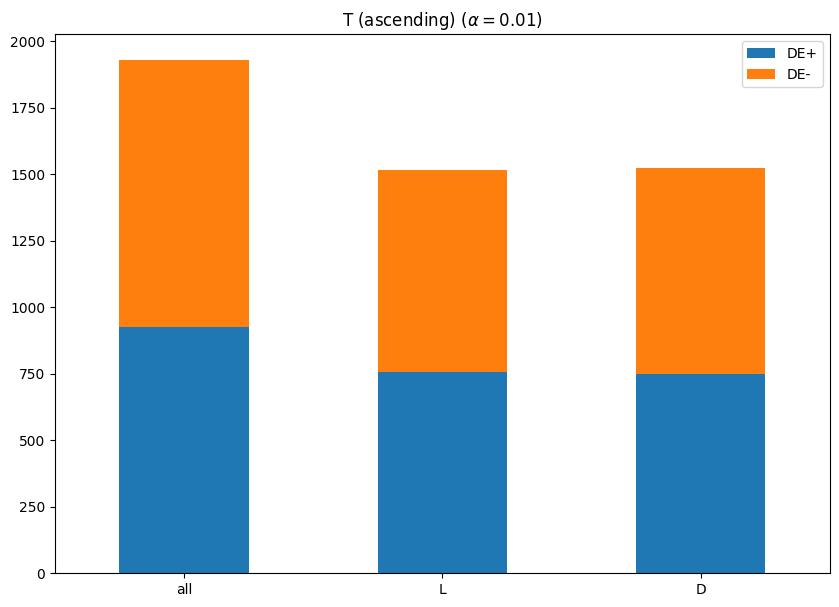

In [9]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

## Remove Light/Dark DE genes from datasets

In [10]:
# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) &
    (TC.index.isin(DE_genes_across_T))
    )]

In [11]:
# Remove light-dark DE genes from TPM dataset
tpm_noDE = tpm.loc[(
    (~tpm.index.isin(DE_all_T)) &
    (tpm.index.isin(DE_genes_across_T))
    )]

In [12]:
# Remove light-dark DE genes from DeSeq2-normalized counts
deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts.index.isin(DE_all_T)) &
    (deseq2_counts.index.isin(DE_genes_across_T))
    )]

deseq2_counts = deseq2_counts.drop("index", axis=1)
deseq2_counts_noDE = deseq2_counts_noDE.drop("index", axis=1)

In [13]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) &
    (counts["index"].isin(DE_genes_across_T))
    )]

## Plot data summaries

Text(0, 0.5, 'Total counts')

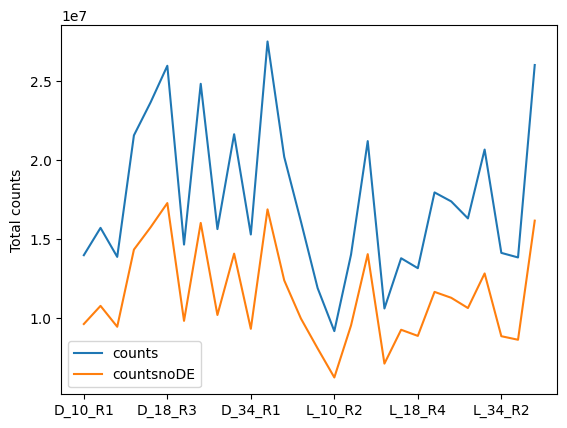

In [14]:
# Total counts sum per sample
ax = pd.concat((counts.set_index("index").sum(),counts_noDE.set_index("index").sum()), axis=1).rename({0: "counts", 1: "countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total counts")

Text(0, 0.5, 'Total TC')

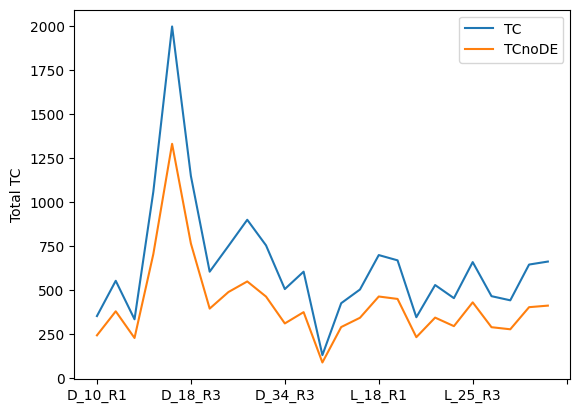

In [15]:
# Total TC sum per sample
ax = pd.concat((TC.sum(), TCnoDE.sum()), axis=1).rename({0: "TC", 1: "TCnoDE"}, axis=1).plot()
ax.set_ylabel("Total TC")

Text(0, 0.5, 'Total TPM')

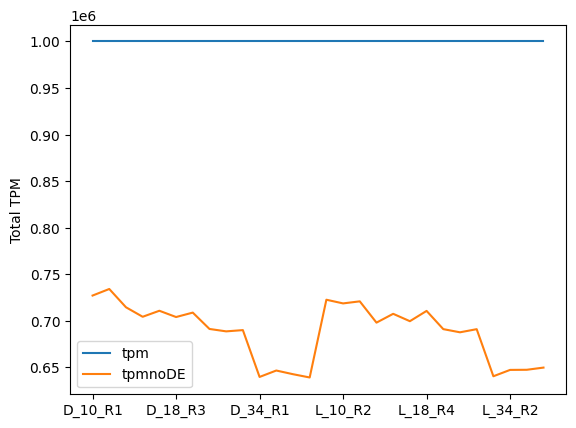

In [16]:
# Total TPM sum per sample
ax = pd.concat((tpm.sum(axis=0),tpm_noDE.sum(axis=0)), axis=1).rename({0: "tpm", 1: "tpmnoDE"}, axis=1).plot()
ax.set_ylabel("Total TPM")

Text(0, 0.5, 'Total deseq2 counts')

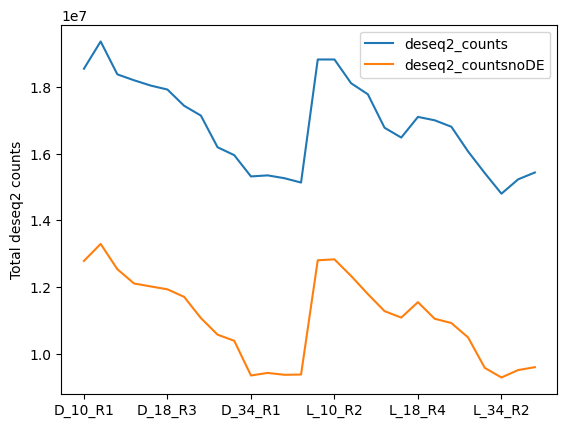

In [17]:
# Total deseq2 counts sum per sample
ax = pd.concat((deseq2_counts.sum(axis=0),deseq2_counts_noDE.sum(axis=0)), axis=1).rename({0: "deseq2_counts", 1: "deseq2_countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total deseq2 counts")

## Find Clusters for TC and TPM

### Transcript / Cell

In [18]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TC = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e2)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Tuesday 18 April 2023 (07:24:38)                     |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

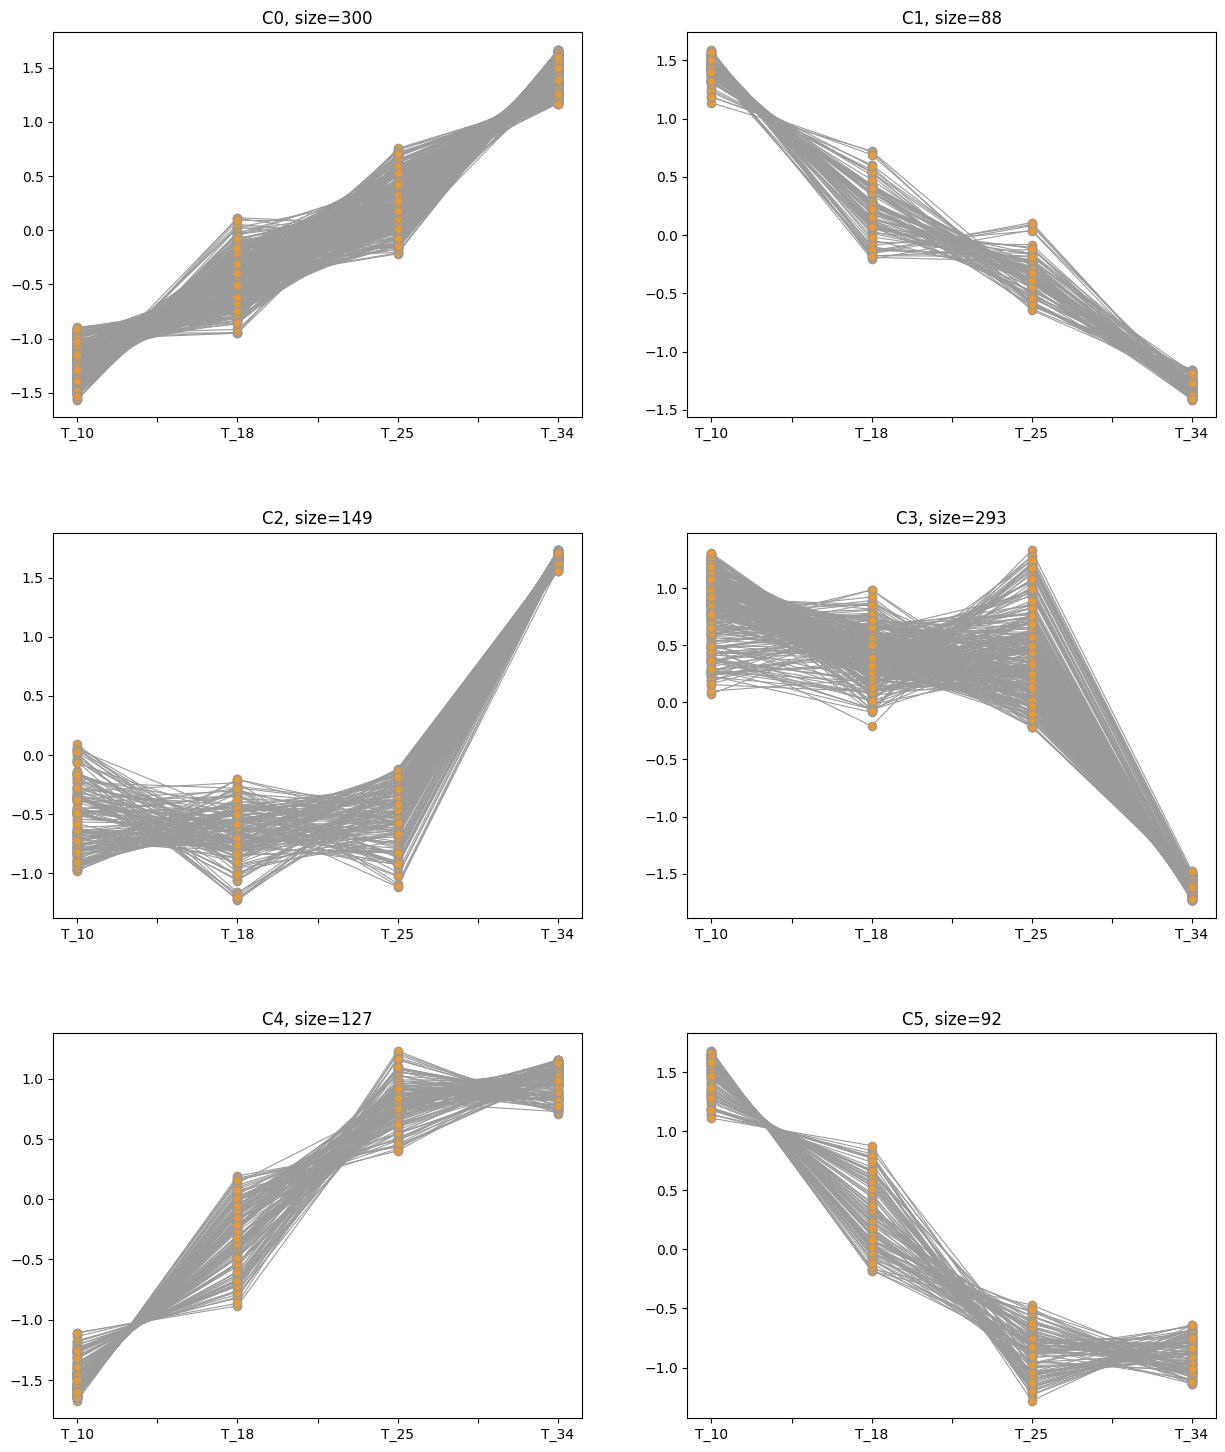

In [19]:
# Merge clusters
clusters_TC = {
    "C0": clusters_TC["C0"],
    "C1": clusters_TC["C5"],
    "C2": clusters_TC["C2"] + clusters_TC["C3"],
    "C3": clusters_TC["C6"] + clusters_TC["C7"],
    "C4": clusters_TC["C1"],
    "C5": clusters_TC["C4"]
}

VI.plotClusters(plot_cluster_data, clusters_TC)

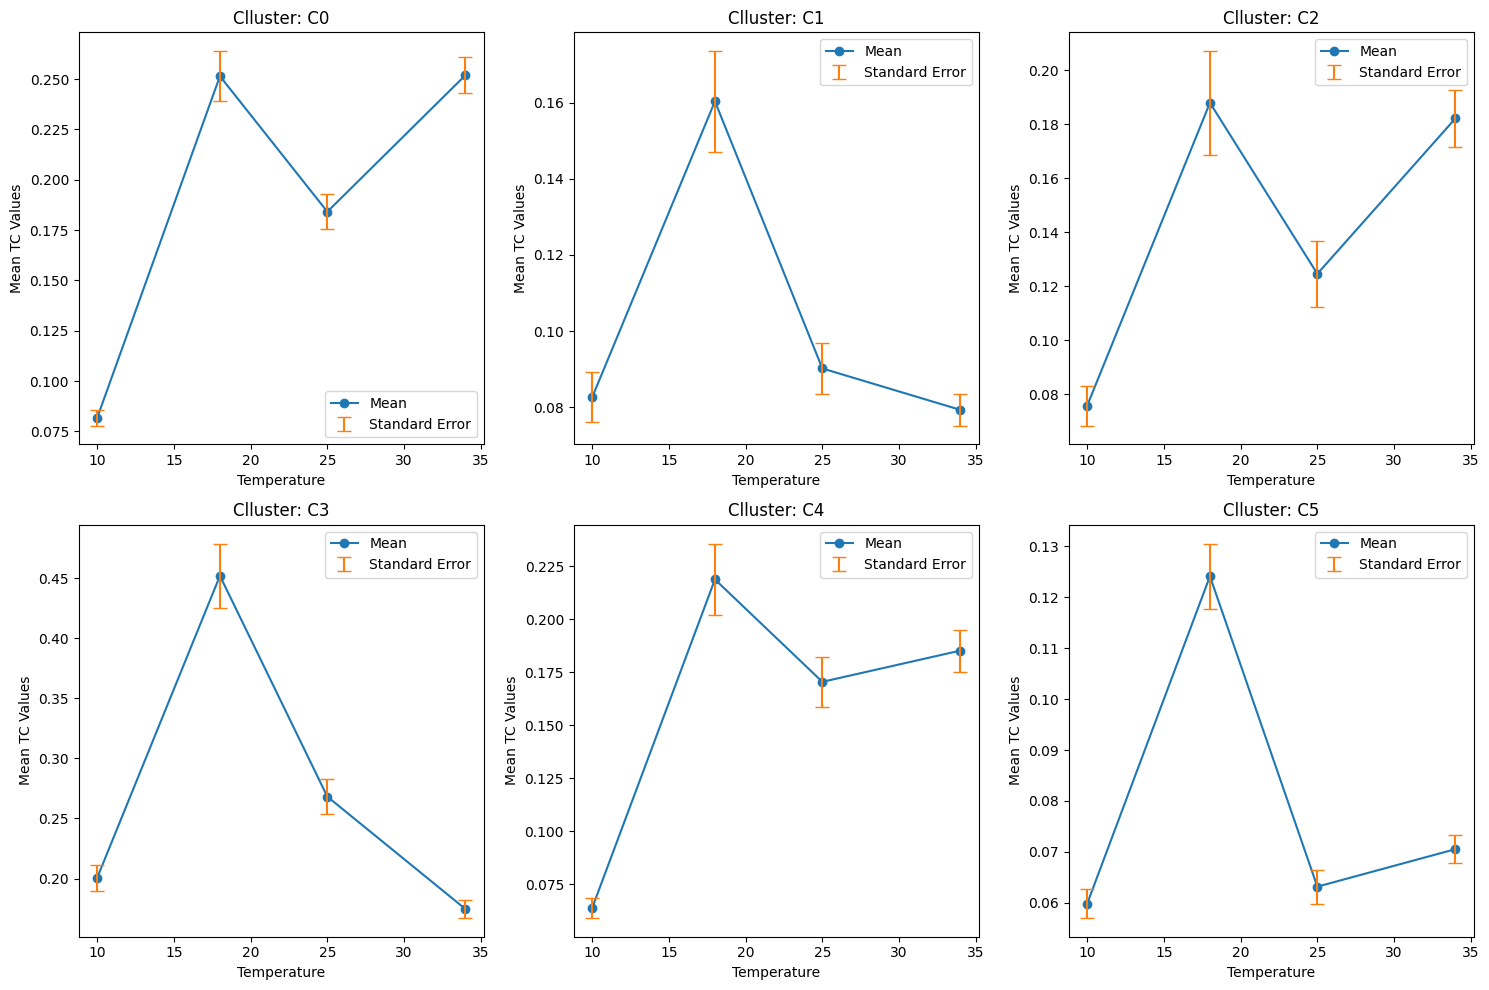

In [20]:
temperatures = [10, 18, 25, 34]
clusters = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for idx, cluster in enumerate(clusters):
    marker_genes = [gene for gene in clusters_TC[cluster]]
    df = TCnoDE.loc[marker_genes, :]

    df_long = df.melt(var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    grouped = df_long.groupby('Temperature')['Value']
    mean_values = grouped.mean()
    standard_error_values = grouped.sem()

    # Plot the mean values
    axs[idx].plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

    # Add error bars for the standard errors
    axs[idx].errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

    # Customize the plot
    axs[idx].set_xlabel('Temperature')
    axs[idx].set_ylabel('Mean TC Values')
    axs[idx].set_title(f'Clluster: {cluster}')
    axs[idx].legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

# TPM

In [21]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TPM'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TPM = CA.getGeneClusters(tpm_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Tuesday 18 April 2023 (07:24:44)                     |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

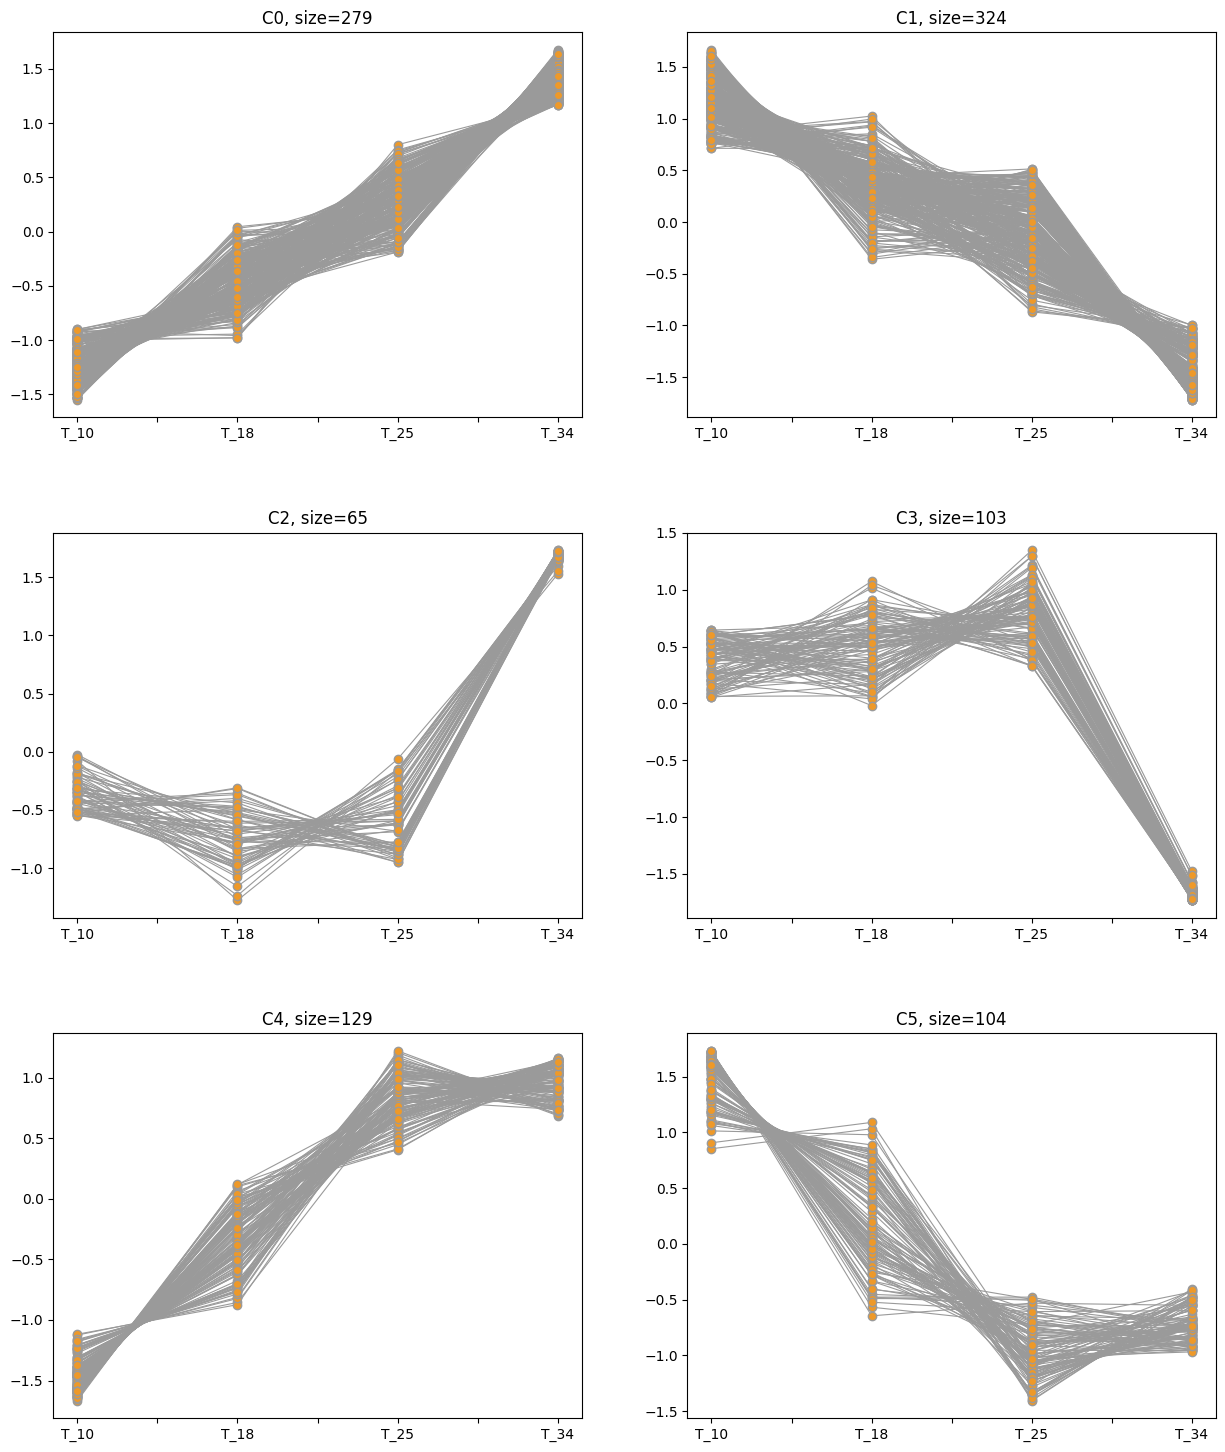

In [22]:
# Merge clusters
clusters_TPM = {
    "C0": clusters_TPM["C0"],
    "C1": clusters_TPM["C4"] + clusters_TPM["C5"],
    "C2": clusters_TPM["C2"],
    "C3": clusters_TPM["C6"],
    "C4": clusters_TPM["C1"],
    "C5": clusters_TPM["C3"] + clusters_TPM["C7"]
}

VI.plotClusters(plot_cluster_data, clusters_TPM)

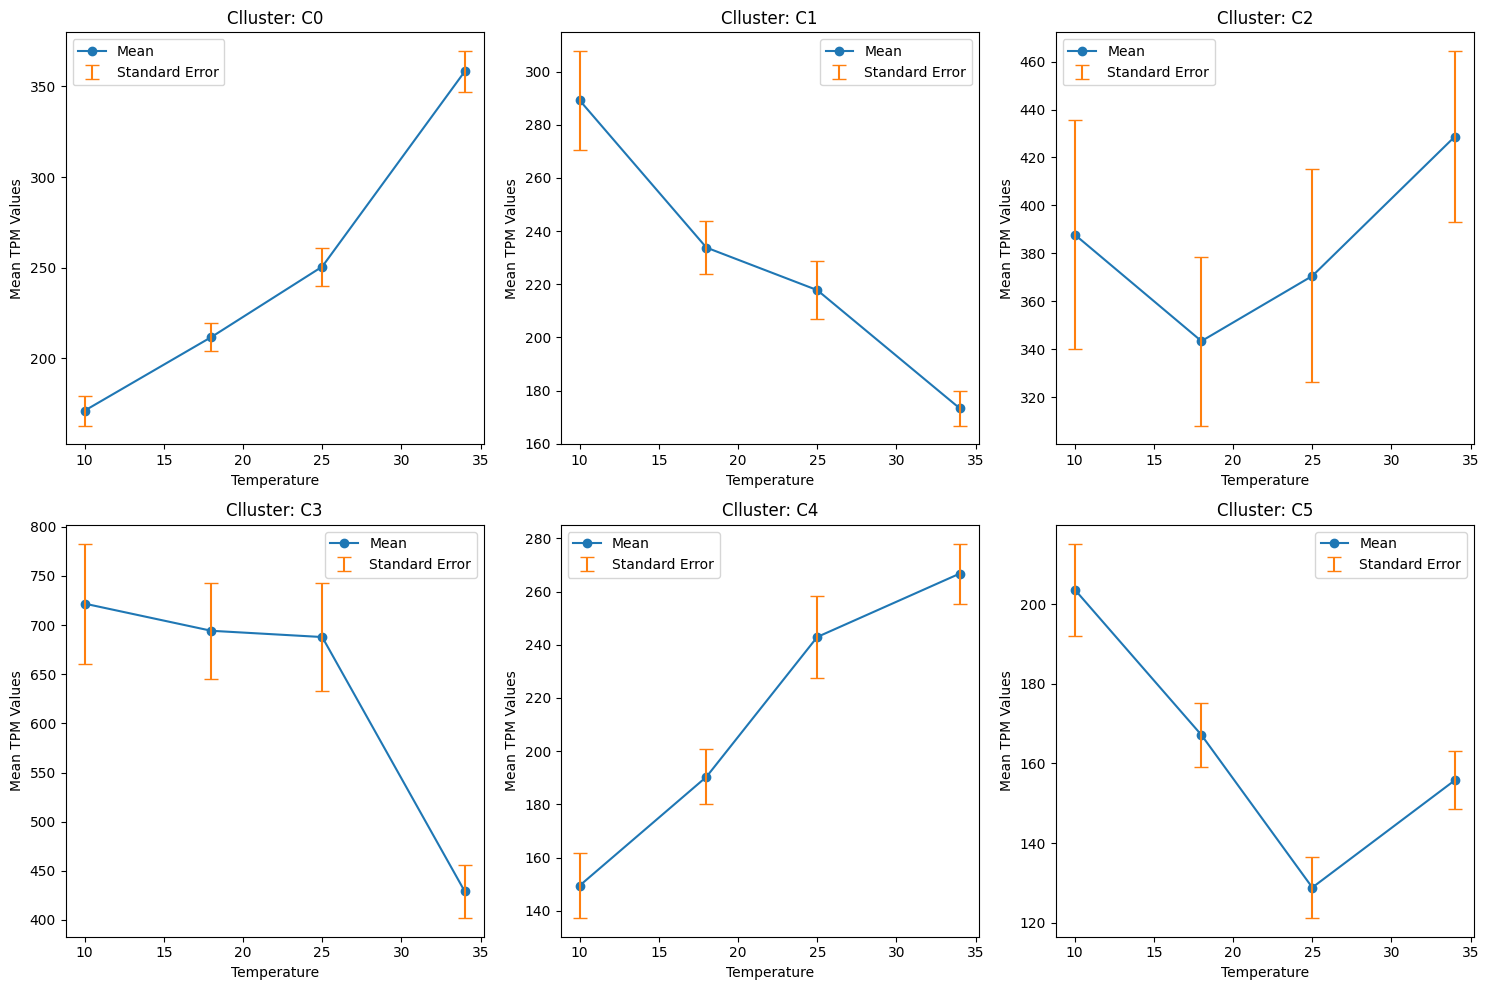

In [23]:
temperatures = [10, 18, 25, 34]
clusters = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for idx, cluster in enumerate(clusters):
    marker_genes = [gene for gene in clusters_TPM[cluster]]
    df = tpm_noDE.loc[marker_genes, :]

    df_long = df.melt(var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    grouped = df_long.groupby('Temperature')['Value']
    mean_values = grouped.mean()
    standard_error_values = grouped.sem()

    # Plot the mean values
    axs[idx].plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

    # Add error bars for the standard errors
    axs[idx].errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

    # Customize the plot
    axs[idx].set_xlabel('Temperature')
    axs[idx].set_ylabel('Mean TPM Values')
    axs[idx].set_title(f'Clluster: {cluster}')
    axs[idx].legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

### Deseq2

In [24]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2 = CA.getGeneClusters(deseq2_counts_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

# VI.plotClusters(plot_cluster_data, clusters_DS2)


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Tuesday 18 April 2023 (07:24:51)                     |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

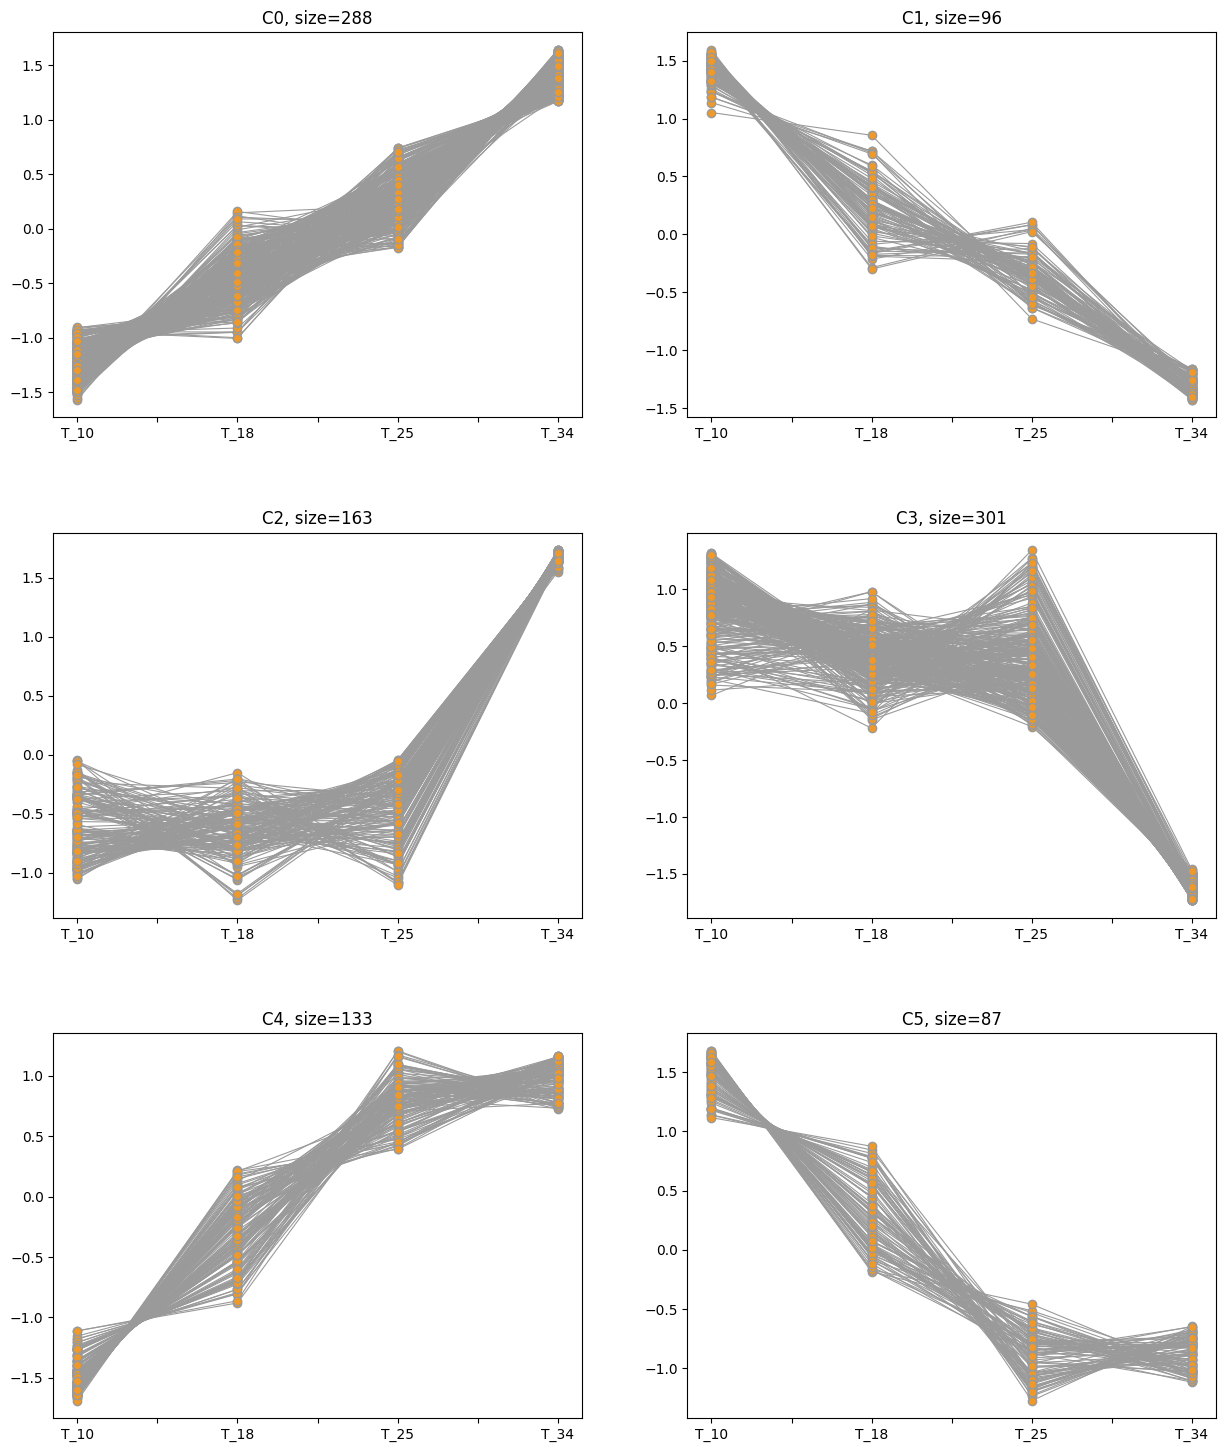

In [25]:
# Merge clusters
clusters_DS2 = {
    "C0": clusters_DS2["C0"],
    "C1": clusters_DS2["C5"],
    "C2": clusters_DS2["C2"] + clusters_DS2["C3"],
    "C3": clusters_DS2["C6"] + clusters_DS2["C7"],
    "C4": clusters_DS2["C1"],
    "C5": clusters_DS2["C4"]
}

VI.plotClusters(plot_cluster_data, clusters_DS2)

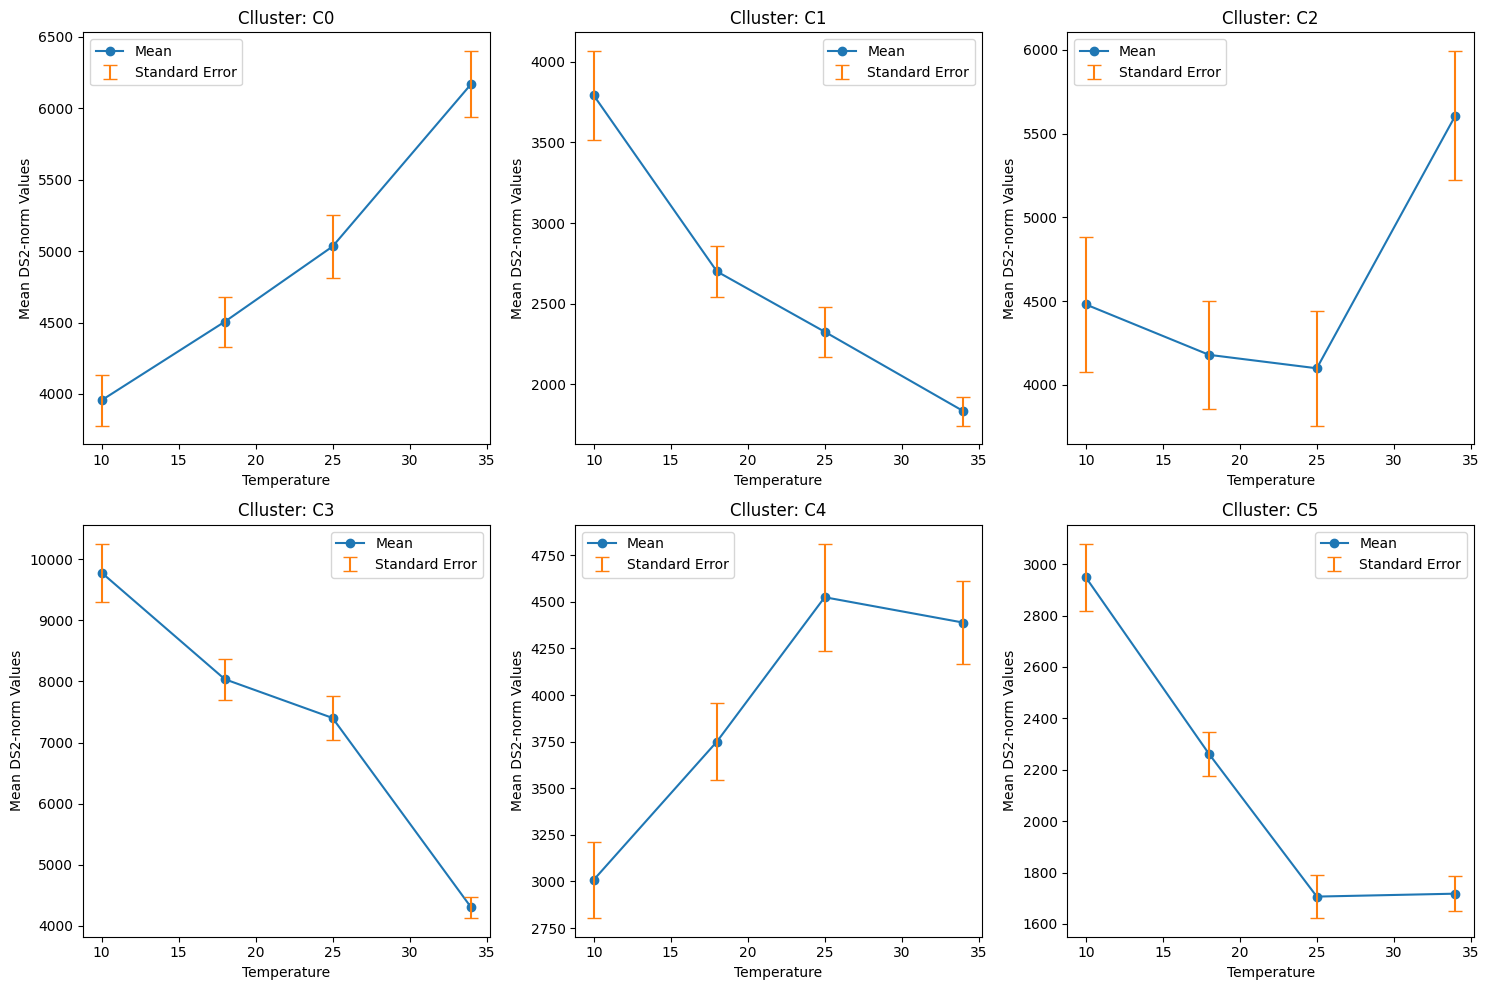

In [26]:
temperatures = [10, 18, 25, 34]
clusters = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for idx, cluster in enumerate(clusters):
    marker_genes = [gene for gene in clusters_DS2[cluster]]
    df = deseq2_counts_noDE.loc[marker_genes, :]

    df_long = df.melt(var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    grouped = df_long.groupby('Temperature')['Value']
    mean_values = grouped.mean()
    standard_error_values = grouped.sem()

    # Plot the mean values
    axs[idx].plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

    # Add error bars for the standard errors
    axs[idx].errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

    # Customize the plot
    axs[idx].set_xlabel('Temperature')
    axs[idx].set_ylabel('Mean DS2-norm Values')
    axs[idx].set_title(f'Clluster: {cluster}')
    axs[idx].legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

## Cluster intersection between TPM and TC

In [27]:
n = 0
for cluster_TC, cluster_TPM in zip(clusters_TC.values(), clusters_TPM.values()):
    # Find intersection
    intersection = set(cluster_TC).intersection(cluster_TPM)
    print(f"Cluster: C{n}\tTC: {len(cluster_TC)}\tTPM: {len(cluster_TPM)} \tIntersection: {len(intersection)}")
    n += 1

Cluster: C0	TC: 300	TPM: 279 	Intersection: 236
Cluster: C1	TC: 88	TPM: 324 	Intersection: 66
Cluster: C2	TC: 149	TPM: 65 	Intersection: 48
Cluster: C3	TC: 293	TPM: 103 	Intersection: 65
Cluster: C4	TC: 127	TPM: 129 	Intersection: 95
Cluster: C5	TC: 92	TPM: 104 	Intersection: 55


## CLuster intersection between DS2 and TC

In [28]:
n = 0
for cluster_TC, cluster_DS2 in zip(clusters_TC.values(), clusters_DS2.values()):
    # Find intersection
    intersection = set(cluster_TC).intersection(cluster_DS2)
    print(f"Cluster: C{n}\tTC: {len(cluster_TC)}\tDS2: {len(cluster_DS2)} \tIntersection: {len(intersection)}")
    n += 1

Cluster: C0	TC: 300	DS2: 288 	Intersection: 284
Cluster: C1	TC: 88	DS2: 96 	Intersection: 88
Cluster: C2	TC: 149	DS2: 163 	Intersection: 134
Cluster: C3	TC: 293	DS2: 301 	Intersection: 289
Cluster: C4	TC: 127	DS2: 133 	Intersection: 126
Cluster: C5	TC: 92	DS2: 87 	Intersection: 87


# Cluster intersection between DS2 and TPM

In [29]:
n = 0
for cluster_TPM, cluster_DS2 in zip(clusters_TPM.values(), clusters_DS2.values()):
    # Find intersection
    intersection = set(cluster_TPM).intersection(cluster_DS2)
    print(f"Cluster: C{n}\tTPM: {len(cluster_TPM)}\tDS2: {len(cluster_DS2)} \tIntersection: {len(intersection)}")
    n += 1

Cluster: C0	TPM: 279	DS2: 288 	Intersection: 230
Cluster: C1	TPM: 324	DS2: 96 	Intersection: 71
Cluster: C2	TPM: 65	DS2: 163 	Intersection: 49
Cluster: C3	TPM: 103	DS2: 301 	Intersection: 65
Cluster: C4	TPM: 129	DS2: 133 	Intersection: 96
Cluster: C5	TPM: 104	DS2: 87 	Intersection: 53


## Cluster marker genes: shared between TC and DeSeq2

In [30]:
cluster_marker_genes = {
    "C0": [
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
        ("MED134_11456","gliding motility protein SprA"),
        ("MED134_11471","periplasmic protein TonB"),
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_02820","dihydrolipoyl dehydrogenase"),
        ("MED134_04959","preprotein translocase, YajC subunit"),
        ("MED134_13511","preprotein translocase subunit SecA"),
        ("MED134_00950","tetrahydrofolate synthase"),
        ("MED134_00060","dihydrofolate reductase"),
        ("MED134_04199","DNA polymerase III, beta subunit"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
        ("MED134_13946","chromosomal replication initiator protein DnaA"),
    ],
    "C1": [
        ("MED134_13511","preprotein translocase subunit SecA"),
        ("MED134_13806","GTP-binding elongation factor family protein TypA/BipA"),
    ],
    "C2": [
        ("MED134_12576","citrate synthase"),
        ("MED134_01775","malate synthase"),
        ("MED134_14121","TonB dependent/ligand-gated channel"),
        ("MED134_00210","TonB dependent/ligand-gated channel"),
        ("MED134_14136","TonB dependent/ligand-gated channel"),
        ("MED134_07224","TonB dependent/ligand-gated channel"),
    ],
    "C3": [
        ("MED134_07436","TonB dependent/ligand-gated channel"),
        ("MED134_08871","metallopeptidase family M36"),
        ("MED134_02950","30S ribosomal protein S1"),
        ("MED134_00540","50S ribosomal protein L13"),
        ("MED134_02405","50S ribosomal protein L1"),
        ("MED134_02425","DNA-directed RNA polymerase beta' chain"),
        ("MED134_02420","DNA-directed RNA polymerase beta chain"),
        ("MED134_02395","transcriptional antitermination factor NusG"),
        ("MED134_01005","translation initiation factor IF-3"),
    ],
    "C4": [
        ("MED134_06674","TonB dependent/ligand-gated channel"),
        ("MED134_00130","electron transfer flavoprotein beta-subunit"),
        ("MED134_00125","electron transfer flavoprotein alpha subunit"),
        ("MED134_06239","acyl-CoA dehydrogenase"),
        ("MED134_07726","methylmalonyl-CoA mutase large subunit"),
        ("MED134_07736","methylmalonyl-CoA mutase small subunit"),
        ("MED134_13066","beta-carotene hydroxylase"),
    ],
    "C5": [
        ("MED134_14787","alanine dehydrogenase"),
        ("MED134_11926","acetylornithine aminotransferase"),
        ("MED134_11941","acetylornithine deacetylase"),
        ("MED134_04309","homoserine kinase"),
        ("MED134_11936","acetylglutamate kinase"),
        ("MED134_11916","N-acetyl-gamma-glutamyl-phosphate reductase"),
        ("MED134_11921","pyrroline-5-carboxylate reductase"),

    ],
}

Let's look at the intersection between marker genes found using transcript/cell and the clusters generated with DeSeq2-normalized data.

In [31]:
for cluster_id, cluster in clusters_DS2.items():
    marker_genes = [gene_id for gene_id, gene_name in cluster_marker_genes[cluster_id]]
    genes_in_cluster = set(cluster).intersection(marker_genes)
    print(f"Cluster: {cluster_id}\tTC Marker Genes in DS2 Cluster: {len(genes_in_cluster) / len(marker_genes) * 100:.2f}%")

Cluster: C0	TC Marker Genes in DS2 Cluster: 92.86%
Cluster: C1	TC Marker Genes in DS2 Cluster: 50.00%
Cluster: C2	TC Marker Genes in DS2 Cluster: 100.00%
Cluster: C3	TC Marker Genes in DS2 Cluster: 100.00%
Cluster: C4	TC Marker Genes in DS2 Cluster: 100.00%
Cluster: C5	TC Marker Genes in DS2 Cluster: 100.00%


Not bad at all. Only cluster C0 has some discrepancies (Cluster C1 not discussed in the paper). Let's find out which genes are out.

In [32]:
cluster = clusters_DS2["C0"]
marker_genes = [gene_id for gene_id, gene_name in cluster_marker_genes["C0"]]
genes_in_cluster = set(cluster).intersection(marker_genes)
genes_not_in_cluster = set(marker_genes).difference(cluster)
print(genes_not_in_cluster) # ("MED134_04199","DNA polymerase III, beta subunit")

{'MED134_04199'}


In [33]:
cluster = clusters_DS2["C1"]
marker_genes = [gene_id for gene_id, gene_name in cluster_marker_genes["C1"]]
genes_in_cluster = set(cluster).intersection(marker_genes)
genes_not_in_cluster = set(marker_genes).difference(cluster)
print(genes_not_in_cluster) # "MED134_13511","preprotein translocase subunit SecA"

{'MED134_13511'}
